# Generating Airfoils from Data-Driven Domains

**Input to define domain**:

- Dataset of 2D shapes (cross sections) with consistent landmarks both in number and reparametrization---i.e., each discrete shape is represented by the same number of landmarks generated by a consistent CST-cosine reparametrization over the shape

- Dependencies detailed below

In [1]:
# Python
import os
import numpy as np
# G2Aero
from g2aero.PGA import PGAspace, Dataset
from g2aero import SPD
from g2aero import Grassmann as gr
#Plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Read PGA space from saved domain
Consistent with the previous notebook [Data-Driven Domain of Shapes](https://g2aero.readthedocs.io/en/latest/how_to_guides/files/0_Data-Driven_Domain.html#), we begin by loading a saved data set of consistently reparametrized discrete airfoil shapes stored in one of the .npz files in `data/airfoils/`.

In [2]:
shapes_folder  = os.path.join(os.getcwd(), '../../data/airfoils/', )
shapes = np.load(os.path.join(shapes_folder, 'CST_shapes_TE_gap.npz'))['shapes']
print("Dataset:")
print(f"Shape of data = {shapes.shape}")
print(f"N_shapes = {shapes.shape[0]}")
print(f"n_landmarks in every shape = {shapes.shape[1]}")

Dataset:
Shape of data = (13000, 401, 2)
N_shapes = 13000
n_landmarks in every shape = 401


## Build PGA space and get coordinates
Next, we build the PGA space from the data set of airfoil shapes. The `PGAspace.create_from_dataset()` method returns a `pga` object and an array of normal coordinates `T` spanning a subspace at the tangent space of the Karcher mean defining a section through the Grassmannian.

In [3]:
# compute Karcher mean and run PGA to define coordinates
pga, t = PGAspace.create_from_dataset(shapes)
_, M, b = pga.shapes2PGA(shapes)
P0 = SPD.Karcher(M)
L3, S3, ell = SPD.PGA(P0,M)

Karcher mean convergence:
||V||_F = 0.10235806971182138
||V||_F = 0.0001552688989775973
||V||_F = 2.711475818136911e-07
||V||_F = 5.985411637820536e-10
Karcher mean convergence:
||V||_F = 0.40098078989714303
||V||_F = 6.627185577609348e-05
||V||_F = 2.746545832747702e-07
||V||_F = 1.9677970483452856e-09


## Random shape generation
We take a simple approach to generate new random shapes over the dominate eigenspaces of coordinate covariance and a random convex combination of SPD matrices. However, more sophisticated approaches to sampling are conceivable. 

In [4]:
np.random.default_rng(seed=42)
# assign r as the dimension of the PGA shape
r = 4 # should always be less than or equal to 2*(n_landmarks - 2)

# compute eigenspaces of covariances over Gr(n,2) and SPD(3) coordinates
Lambda_t, W_t = np.linalg.eigh(1/np.sqrt(t.shape[0]-1)*( t[:,:r].T @ t[:,:r]))

# sample a random coordinate with reduce variation to protect against self-intersection
rnd_t = (W_t @ np.diag(Lambda_t)) @ np.random.normal(0,0.25,size=(r,1))

# use the random coordinates and a random combination of SPD matrices to sample a random shape
rnd_i = np.random.randint(ell.shape[0],size=2)
rnd_shape = pga.PGA2shape(rnd_t.flatten(),M=0.5*(M[rnd_i[0],:,:] + M[rnd_i[1],:,:]),b=pga.b_mean)
# or generate the random shape with an extrinsic-average scale
rnd_shape_avg = pga.PGA2shape(rnd_t.T,M=pga.M_mean,b=pga.b_mean)

# the process of generating random shape with extrinsic average scale is also automated using:
rnd_shape_auto, _, _ = pga.generate_perturbed_shapes(coef=rnd_t.T,n=1)

Then we plot all of our randomly generated shapes to compare them visually. The automatically generated shape is given consistent coordinates as the avgerage scale shape, thus those two shapes should overlap in the plot.

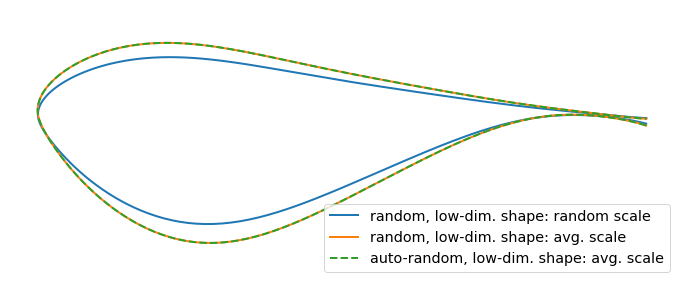

In [5]:
# plot the low-dimensional shape and the original shape
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.plot(rnd_shape[:,0], rnd_shape[:,1],linewidth=2, label='random, low-dim. shape: random scale')
plt.plot(rnd_shape_avg[:,0], rnd_shape_avg[:,1],linewidth=2, label='random, low-dim. shape: avg. scale')
plt.plot(rnd_shape_auto[:,0],rnd_shape_auto[:,1],'--',linewidth=2, label='auto-random, low-dim. shape: avg. scale')
# formatting
plt.axis('off')
ax.axis('equal')
ax.legend(fontsize='x-large')